# Cluster Analysis on Poisonous Mushrooms
### Badger, Badger, Badger, Badger, Mushroom, Mushroom! 


Humans have evolved to be incredibly good at finding patterns, which has allowed us to know which plants are safe to eat and which should best be left alone. In this notebook I'll be investigating properties of mushrooms. The dataset contains over 8000 examples of mushrooms that are either safe or poisonous. 

## Tasks 
- Visualize patterns in the data
- Create a Mixture Model to describe data
- Iterate and evaluate model

In [17]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set_style("dark")

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Dimensionality Reduction

There are 126 different attributes in the data, unfortunately we can visualize 3 of these effectively. Let's see if some Principal Component Analysis can't ease our troubles.

In [5]:
def reduce_dimension(data,n_dimensions): #This fn will help out later
    return PCA(n_components = n_dimensions).fit_transform(data)
two_dim = reduce_dimension(train_data,2)

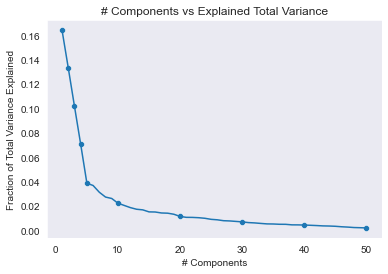

In [18]:
def ComponentsVSVariance(k_values):
    pca = PCA(n_components=50)
    first_50 = pca.fit(train_data).explained_variance_ratio_ #fit PCA
    
    sns.scatterplot(x=k_values, y=[first_50[k-1] for k in k_values]) #plot points at specified k_values
    sns.lineplot(x=np.arange(1,51),y=first_50) #plot all explained variances
    
    plt.title("# Components vs Explained Total Variance")#plot aesthetics
    plt.xlabel("# Components")
    plt.ylabel("Fraction of Total Variance Explained")
    return 

ComponentsVSVariance([1, 2, 3, 4, 5, 10, 20, 30, 40, 50])

### Initial Visualization

Let's see if a 2D projection of the training data shows us any info

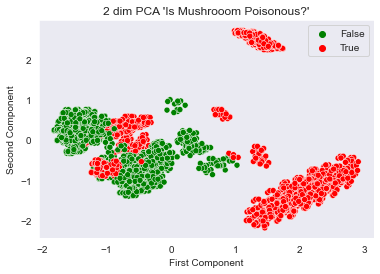

In [35]:
def P2():
    fig,axs = plt.subplots(1,1)
    sns.scatterplot(x=two_dim[:,0],y=two_dim[:,1],hue = train_labels.astype("bool") ,palette = ("green","red")) #split by poisonous mushrooms
    plt.xlabel("First Component")#plot aesthetics
    plt.ylabel("Second Component")
    plt.title("2 dim PCA 'Is Mushrooom Poisonous?'")
    return 
P2()

#### Looks like our mushrooms can be split up into fairly seperable groups. Unfortunately we can't say for sure what the two components are in language that makes sense

### K-Means Cluster Model

Let's do K-Means with 6 clusters the algorithm finds

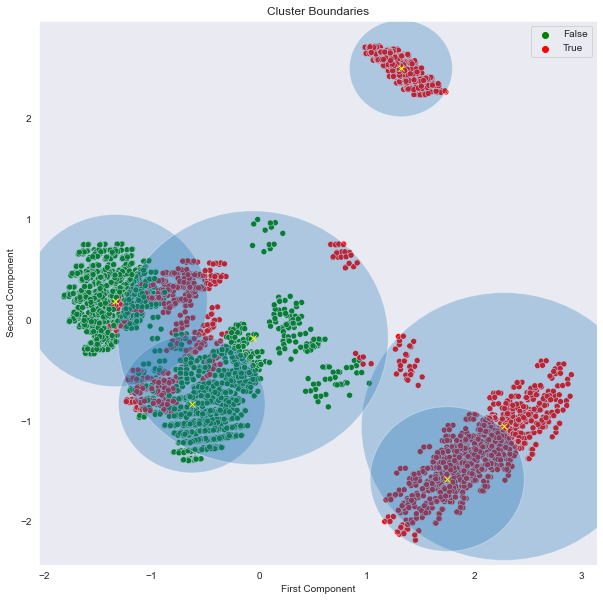

In [33]:
def K_means():
    fig, axs = plt.subplots(figsize = (10,10))
    
    clusterer = KMeans(n_clusters = 6, random_state=0)#initialize KMeans and fit
    clustered_2D_data = clusterer.fit(two_dim)
    clusters = clustered_2D_data.cluster_centers_#find center point of clusters
    
    sns.scatterplot(x=two_dim[:,0],y=two_dim[:,1],ax = axs,hue = train_labels.astype("bool"),palette = ("g","r"))#display 2D data
    
    for i, center in enumerate(clusters):
        points = two_dim[clustered_2D_data.labels_==i] 
        radius = max([LA.norm(point-center) for point in points]) #max distance from cluster center
        axs.add_artist(plt.Circle((center[0], center[1]),radius,alpha=.3)) #plot circle
        plt.plot(center[0],center[1],marker = "x",alpha=1,c="yellow") #plot center of cluster
    
    plt.title("Cluster Boundaries")
    plt.xlabel("First Component")#plot aesthetics
    plt.ylabel("Second Component")
    return plt.show()
K_means()

### Gaussian Mixture Model

Let's try iterating through some parameters for a GMM and see how they affect the associated model. The model will be looking at all positive (poisonous) mushrooms in the dataset

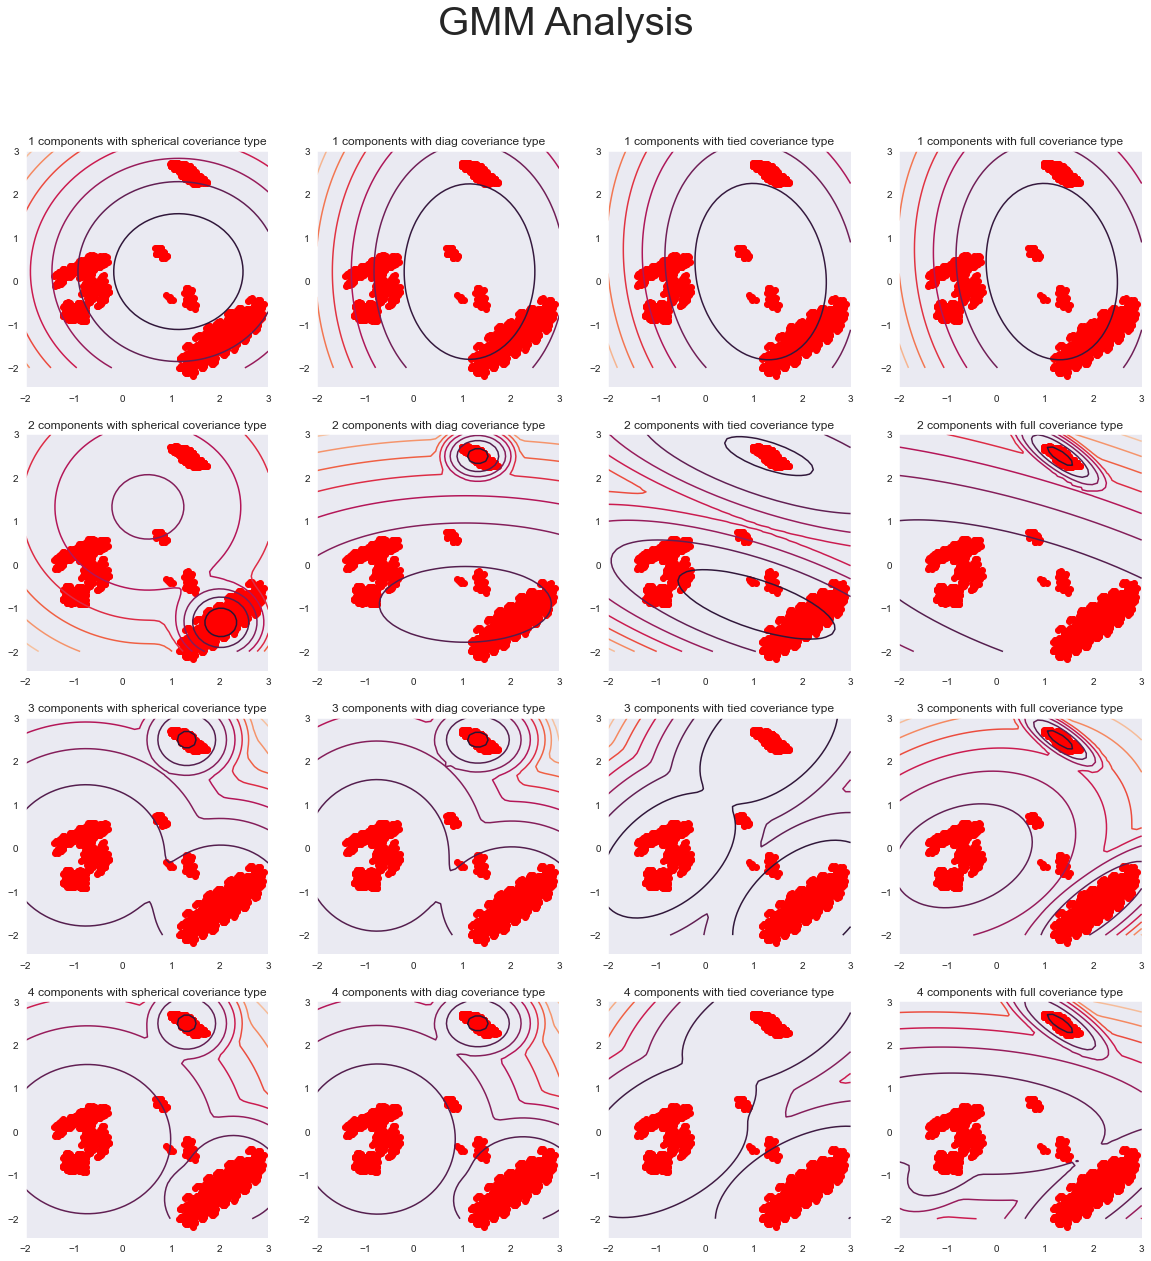

In [24]:
def MixtureModelIteration():
    fig,axs = plt.subplots(4,4,figsize=(20,20))
    for n in np.arange(4): #for n_components
        for i, matrix_type in enumerate(['spherical', 'diag', 'tied', 'full']):
            positives = two_dim[train_labels==1]
            model = (GaussianMixture(n_components = n+1,covariance_type = matrix_type)
                     .fit(positives)) #GMM initialization and fit
            
            x,y = np.linspace(-2, 3),np.linspace(-2, 3)#define endpoints
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T #taken from documentation example
            Z = -model.score_samples(XX)
            Z = Z.reshape(X.shape)
            
            axs[n][i].scatter(positives[:,0],positives[:,1],c="red")#plotting
            axs[n][i].contour(X, Y, Z)
            axs[n][i].set_title(str(n+1)+" components with "+matrix_type + " coveriance type")
    fig.suptitle('GMM Analysis',size=40)
        

MixtureModelIteration()

# Prediction

I'll fit two Gaussian Mixture Models, one for poisonous mushroom and one for safe ones, and then predict labels by choosing the larger of the two models' probabilities. 

In [32]:
def prediction(dimensions=2,components=4,matrix_type="full"): #reuse fn in part 6
    
    reduced = reduce_dimension(train_data,dimensions) # transform data
    
    def find_probabilities(points,test):
        model= GaussianMixture(n_components=components,covariance_type=matrix_type,random_state = 3).fit(points)
        return np.exp(model.score_samples(test))
    
    positives = reduced[train_labels==1] #separate the data
    negatives = reduced[train_labels==0]
    reducedTest = reduce_dimension(test_data,dimensions)
    
    positive_model_probabilities = find_probabilities(positives,reducedTest)
    negative_model_probabilities = find_probabilities(negatives,reducedTest)
    zipped_probabilities = list(zip(positive_model_probabilities,negative_model_probabilities))
    
    predictions = [1 if p[0]>=p[1] else 0 for p in zipped_probabilities]#compare elementwise
    accuracy = metrics.accuracy_score(predictions,test_labels)
    return accuracy

print("Model has accuracy of " + str(round(prediction()*100,2))+"%")    

Model has accuracy of 92.79%


### That's pretty good!

### Model Iteration

Now let's find the best model by doing a grid search over the PCA dimension, GMM count, and covariance matrix type. 

In [34]:
def model_iteration():
    def find_num_parameters(n_pca,n_gmm,matrix_type): #based off eqn found in given excel sheet
        if matrix_type == "full":
            return ((n_pca*n_gmm) + n_pca*((n_pca + 1)/ 2))*2
        elif matrix_type == 'diag':
            return (n_pca*n_gmm + n_pca * n_gmm) * 2
        elif matrix_type == "spherical":
            return (n_pca*n_gmm + n_gmm) * 2
        else:
            return ((n_pca*n_gmm) + n_pca*((n_pca + 1)/ 2))*2
        
    PCA_array = np.arange(1,10)
    components_array = np.arange(1,10)
    covariance_type_array = ["spherical","diag","full","tied"]
    parameter_array = []
    accuracies = []
    
    for pca_num in PCA_array:                 #yuck triple nested for loop, I'm sorry
        for component_num in components_array:#grid of all possible model parameters
            for matrix_type in covariance_type_array:
                if find_num_parameters(pca_num,component_num,matrix_type) <=50: 
                    
                    parameter_array.append([pca_num,component_num,matrix_type])#store parameters
                    accuracies.append(P5(pca_num,component_num,matrix_type))#populate accuracy array
                    
    max_stats = parameter_array[np.argmax(accuracies)]#this is the best model
    
    return ("The optimal GMM with 50 or less parameters has "+str(round(max(accuracies)*100,4))+"% accuracy"+
            " with " + str(max_stats[1])+ " components and a " + max_stats[2] +" covariance type " +
            "trained on " + str(max_stats[0]) + " dimensional data.")

model_iteration()

'The optimal GMM with 50 or less parameters has 94.306% accuracy with 6 components and a spherical covariance type trained on 3 dimensional data.'